<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/Bayes-by-Backprop/notebooks/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install scipy==1.1.0 -q
!pip install tensorflow==2.0.0b1 -q

In [0]:
from autograd import grad
from autograd.misc import flatten
from autograd.misc.optimizers import adam, sgd
import autograd.numpy.random as npr
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.scipy.stats.norm as norm
import pandas as pd
import warnings
import tensorflow as tf
    
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('white')
π = np.pi

# 5.1. Classification on MNIST

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# 5.2. Regression curves

$$ \mathcal{D}=\left\{x,y\right\}=\left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^N$$
$$ x,y \in \mathbb{R}^N $$

$$y = x + 0.3 \sin(2\pi(x + \epsilon)) + 0.3 sin(4\pi(x + \epsilon)) + \epsilon$$

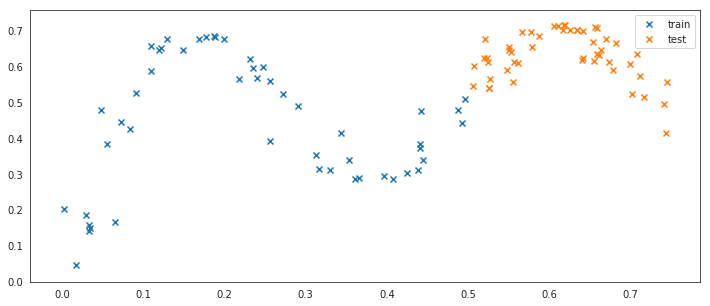

In [2]:
def scatter_plot(*data, legend):
    plt.figure(figsize=(12,5))
    for d in data:
        ax = plt.scatter(*d, marker='x')
    plt.legend(legend)
    return ax


def make_data(N):
    def f(x):
        ϵ = 0.02*np.random.randn(x.shape[0])
        return x + 0.3*np.sin(2*π*(x + ϵ)) + 0.3*np.sin(4*π*(x + ϵ)) + ϵ
    
    x_train = 0.5*np.random.rand(N)
    x_test = 0.25*np.random.rand(N) + 0.5
    y_train = f(x_train)
    y_test = f(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = make_data(50)

scatter_plot((x_train, y_train),
             (x_test, y_test),
             legend=['train', 'test']);

$$h = \sigma(W_1x + b_1)$$
$$\hat{y} = W_2h + b_2 $$

In [0]:
# reference: 
# https://github.com/HIPS/autograd/blob/master/examples/neural_net_regression.py

def relu(z):
    return z*(z > 0)


def mse(y_true, y_pred):
    return np.power(y_true - y_pred, 2).mean()


def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]


def nn_predict(params, inputs):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = relu(outputs)
    return outputs


def log_likelihood(params, x: np.array, y: np.array,
                   noise_scale: float=0.1) -> float:
    predictions = nn_predict(params, x)
    return np.sum(norm.logpdf(predictions, y, noise_scale))


def weight_prior(params, variance):
    flat_params, _ = flatten(params)
    if variance == 0:
        return 0
    return norm.logpdf(flat_params, 0, variance).sum()


def loss(params, x: np.array, y: np.array, 
         noise_scale=0.1, weight_prior_variance=1) -> float:
    return (-log_likelihood(params, x, y, noise_scale)
            - weight_prior(params, weight_prior_variance))

## Tests

In [0]:
W1, b1, W2, b2 = (np.eye(3), np.zeros(3),
                  np.eye(3), np.zeros(3))
params = ((W1, b1), 
          (W2, b2))

x = np.array([-1, 0, 1])
y = np.array([0, 0, 1])
σ = 1/np.sqrt(2*π)

weight_prior_variance = σ
noise_scale = σ

# test neural_net_predict
assert np.isclose(nn_predict(params, x), y).all()

# test log_likelihood
y_ = y + 1
assert log_likelihood(params, x, y, noise_scale) == 0
assert np.isclose(log_likelihood(params, x, y_, noise_scale), -3*π)

# # test l2_regularization
assert np.isclose(weight_prior(params, weight_prior_variance), -6*π)

## Learning

### Gradient Descent (GD)

0 loss: 3226869.3814436384
100 loss: 3226838.081326381
200 loss: 3226838.0716164177
300 loss: 3226838.062098741
400 loss: 3226838.0527695394
500 loss: 3226838.04362508
600 loss: 3226838.034661708
700 loss: 3226838.025875835
800 loss: 3226838.0172639494
900 loss: 3226838.0088226018


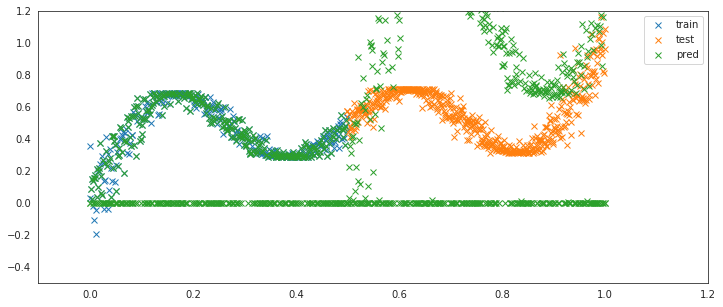

In [8]:
N = 500
x_train, y_train, x_test, y_test = make_data(N)
input_size = x_train.shape[0]
hidden_layer_size = 1_000
output_size = y_train.shape[0]
lr = 0.01
λ = 10

# compute gradient
loss_grad = grad(loss)

# init params
params = init_random_params(input_size, hidden_layer_size, 
                            output_size, scale=0.01, seed=0)

# Gradient Descent
losses = list()
for i in range(1_000):
    loss_args = (params, x_train, y_train, 1, λ)
    Δparams  = loss_grad(*loss_args)   
    params = [p - Δp*lr for p, Δp in zip(params, Δparams)]
    l = loss(*loss_args)
    losses.append(l)
    
    if i % 100 == 0:
        print(i, f'loss: {l}')

# Plot
plot_option = dict(
    style='x', 
    figsize=(12,5),
#     ylim=(-0.5, 1.2),
#     xlim=(-0.1, 1.2)
)


y_pred = np.concatenate((neural_net_predict(params, x_train),
                         neural_net_predict(params, x_test)))
x_pred = np.concatenate((x_train, x_test))

train = pd.Series(y_train, x_train).rename('train')
test = pd.Series(y_test, x_test).rename('test')
pred = pd.Series(y_pred, x_pred).rename('pred')

pd.concat((train, test, pred), axis=1).plot(**plot_option);

### SGD

Iteration 0 log likelihood 1663458.4364934382, mse 0.3971224425105575
Iteration 1 log likelihood 1663456.5141712357, mse 0.39345802119019246
Iteration 2 log likelihood 1663452.9093911897, mse 0.38657235995349276
Iteration 3 log likelihood 1663447.8712102927, mse 0.3769251691436598
Iteration 4 log likelihood 1663441.6479796532, mse 0.36496968057003587
Iteration 5 log likelihood 1663434.4774357474, mse 0.35113259607673314
Iteration 6 log likelihood 1663426.5806869387, mse 0.33581026150792426
Iteration 7 log likelihood 1663418.1574886972, mse 0.3193620217749308
Iteration 8 log likelihood 1663409.3847910364, mse 0.3021026706433066
Iteration 9 log likelihood 1663400.4166925391, mse 0.2843052677340126
Iteration 10 log likelihood 1663391.384765017, mse 0.26619936511956416
Iteration 11 log likelihood 1663382.4008740052, mse 0.24797731110702337
Iteration 12 log likelihood 1663373.5589403133, mse 0.2297967836781602
Iteration 13 log likelihood 1663364.939177269, mse 0.2117873034245099
Iteration 1

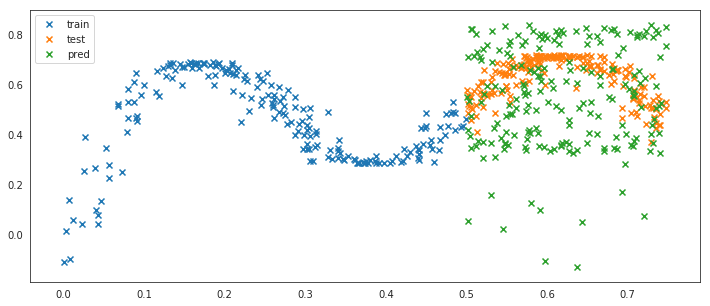

In [41]:
# parameters
N = 200
hidden_layers_size = 300
n_hidden_layers = 3
layer_sizes = [N, *(n_hidden_layers*[hidden_layers_size]),  N]
weight_prior_variance = 10
params_init_scale = 0.01
step_size = 0.01
num_iters=100

# learn
x_train, y_train, x_test, y_test = make_data(N)
params_init = init_random_params(params_init_scale, layer_sizes)
losses = list()
mses = list()
params_best = None
mse_best = float('inf')

def objective(params, i):
    return loss(params, x_train, y_train, noise_scale, weight_prior_variance)

def callback(params, i, g):
    l = loss(params, x_train, y_train, noise_scale, weight_prior_variance)
    y_pred = nn_predict(params, x_test)
    s = mse(y_test, y_pred)
    global mse_best
    global params_best
    if s < mse_best:
        params_best = params
        mse_best = s
        print(f"Iteration {i} log likelihood {l}, mse {s}")
    losses.append(l)
    mses.append(s)

optimized_params = sgd(grad(objective), params_init,
                        step_size=step_size, 
                        num_iters=num_iters,
                        callback=callback)

# plot
y_pred = nn_predict(params_best, x_test)
scatter_plot((x_train, y_train),
             (x_test, y_test),
             (x_test, y_pred),
             legend=['train', 'test', 'pred']);

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


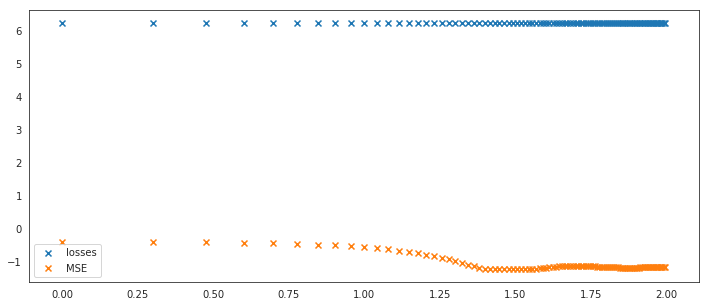

In [42]:
i = np.log10(range(num_iters))

scatter_plot((i, np.log10(losses)),
             (i, np.log10(mses)),
             legend=['losses', 'MSE']);